**Student Name**: Igor Schittekat

**Student ID**:s0160651

# Lab 4: Monte Carlo Methods

### Instructions: **TODO** tags
In this lab, you will implement Monte Carlo methods. In particular, there will be 3 main steps:
1. **Policy Evaluation**: provided an arbitrary policy $\pi$, compute its value function $v_\pi$ using MC. You will be asked to compare your results to the exact solution you will find with Dynamic Programming.
2. **On-Policy MC Control**: implement MC to find an optimal soft policy, using an $\epsilon$-greedy policy.
3. **Off-Policy MC Control**: same idea using an $\epsilon$-greedy behavior policy and learning the optimal policy.

As usual, please *read* and *run* the notebook chronologically, and fill in the **TODO**s as you encounter them.
* <span style="color:blue"> Blue **TODOs** </span> means you have to implement the TODOs in the code.
* <span style="color:red"> Red **TODOs** </span> means you have to submit an explanation (of graph/results/theory).

### Environment
Below are the libraries we will use and the Environment.

The Environment for this lab and the next lab on tabular RL is called the **Four Rooms** Environment. It simply contains 4 rooms of fixed size $5\times5$ in our case- in which the agent can move around, as in a house. There is no noise in the dynamics, meaning that the 4 directional actions deterministically take you to the requested neighboring state. Unless stated otherwise, the agent starts from the upper left corner. It will always have to reach the terminal state in the lower right corner to get a sparse reward of $+1$; any other transition gives reward $0$. A visualization will follow.

In [1]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals
import numpy as np
import gym
from gym import spaces
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib import cm
import random
from copy import copy

In [2]:
class FourRoomsEnv(gym.Env):
    """ Small Gridworld environment with 4 rooms.
    Starting up left, goal in lower-right.
    The main challenge is that the reward is sparse (1_goal)
        """
    def __init__(self, explo_starts=False, max_steps=None):
        self.roomsize = 5
        self.height = 2*self.roomsize +1 # +1 is obstacle width
        self.width = self.height
        half = self.width // 2 # shortcut
        quarter = half // 2 # shortcut
        self.gamma = 0.9
        self.t = 0
        self.max_steps = max_steps
        self.explo_starts = explo_starts
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
                spaces.Discrete(self.height),
                spaces.Discrete(self.width)
                ))
        self. shapes = (tuple([self.observation_space.spaces[i].n for i in range(len(self.observation_space.spaces))]), 
                        self.action_space.n)

        self.moves = {
                0: (-1, 0),  # up
                1: (0, 1),   # right
                2: (1, 0),   # down
                3: (0, -1),  # left
                }
        self.moves_to_str = {
                0: u'↑',
                1: u'→',
                2: u'↓',
                3: u'←',
                }
        
        self.terminal = (self.height-1,self.width-1) # terminal state
        horizontal  = [(i, half) for i in range(self.width)]
        vertical    = [(half, i) for i in range(self.height)]
        self.obstacles = horizontal + vertical
        # now opening the 4 passages
        for state in [(quarter,half), (half,quarter), (half,self.height-quarter), (self.height-quarter,half)]:
            self.obstacles.remove(state)
        self.start = (0,0)
        # begin in start state
        self.reset()

    def reset(self):
        if self.max_steps is not None:
            self.t = 0
        if self.explo_starts:
            while True:
                s = self.observation_space.sample()
                if s not in self.obstacles + [self.terminal]:
                    break
            self.s = s
            #print("Random Start at S={}".format(s))
                
        else:
            self.s = self.start
        return self.s

    def step(self, action):
        """ Moves the agent in the action direction."""
        # Next, moving according to action
        x, y = self.moves[action]
        if (self.s[0]+x, self.s[1]+y) not in self.obstacles:
            # move is allowed
            self.s = self.s[0] + x, self.s[1] + y

            # Finally, setting the agent back into the grid if fallen out
            self.s = (max(0, self.s[0]), max(0, self.s[1]))
            self.s = (min(self.s[0], self.height - 1),
                      min(self.s[1], self.width - 1))

        self.t += 1
        done_goal = (self.s == self.terminal)
        done = done_goal
        if self.max_steps is not None and self.t == self.max_steps:
            done = True
            self.t = 0
        return self.s, int(done_goal), done, {}
    
    def is_terminal(self, state):
        return state == self.terminal
    
    def p(self, state, action):
#         assert not self.is_terminal(state)
        self.s = state
        next_state, reward, done, info = self.step(action)
        return {(next_state, reward): 1}
    
    def states(self):
        ss = []
        for i in range(self.height):
            for j in range(self.width):
                if (i,j) not in self.obstacles:
                    ss.append((i,j))
        return ss 
    
    def plot_values_policy(self, values, policy, plot_all_policy=False, cbar=True):
        """ Visualizes a policy and value function given an agent with V and policy."""
        fig, ax = plt.subplots()
        values[tuple(zip(*self.obstacles))] = None # -1
        cmap = copy(cm.get_cmap("RdYlGn"))
        # modify colormap
        l = np.array([cmap(i) for i in range(cmap.N)]).T
        l[0:2] = np.clip(l[0:2], 0,0.9)
        l[2] = np.clip(l[2], 0,0.25)
        l = l.T
        my_cmap = matplotlib.colors.ListedColormap(l, name = 'nani')
        my_cmap.set_bad('black')

        im = ax.imshow(values, cmap=my_cmap)
        for i in range(self.height):
            for j in range(self.width):
                s = (i,j)
                if s not in self.obstacles:
                    t = self.moves_to_str[policy[s]] if not self.is_terminal(s) \
                                                        and ((values[s] != 0) or (plot_all_policy)) else ""
                    text = ax.text(j, i, t,
                                   ha="center", va="center", color="w", fontsize=15)

        ax.set_title("Value function and Policy visualization")
        fig.tight_layout()
        if cbar:
            plt.colorbar(im)
        plt.show()

## 1. Policy Evaluation

### 1.1 Defining and visualizing the policy
Let's define and visualize an arbitrary *deterministic* policy $\pi$. We're picking a deterministic policy for ease of visualization and understanding of the learning process. 

Since we know we only need to go south and east to solve the task, let's use a policy that only picks between these two. We're plotting in green the terminal state we want to reach; later, the colors will correspond to state values. The dark squares correspond to walls.

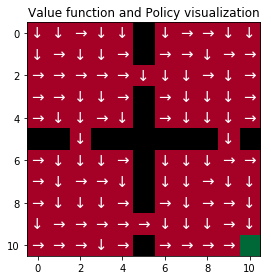

In [3]:
# Defining the environment
np.random.seed(54)
env = FourRoomsEnv()
# Defining the policy
pi = {s:np.random.choice([1,2]) for s in env.states()}
# Visualizing the environment and policy
zero_values = np.zeros(env.shapes[0])
zero_values[env.terminal] = 1
env.plot_values_policy(zero_values, pi, plot_all_policy = True, cbar=False)
np.random.seed(None)

### 1.2. <span style="color:blue"> **TODO** </span> DP Policy Evaluation (1pt)
We want to evaluate $v_\pi$ for this policy. Note that we could also compute $q_\pi$, it doesn't really matter if we're not looking to extend to control!

We will first use what we know works, i.e., **Dynamic Programming**'s Policy Evaluation, then implement Monte Carlo to compare the results.

- <span style="color:blue"> **TODOs** </span>: Implement **DP_PolicyEvaluation**. This will be similar to the Policy and Value Iteration agents from the previous lab, we're providing an MDP as input and implement a `run` method to compute the values. Instead of a dictionary as before, we will now use a **numpy array** to store the $v$ and $q$ from now on, as it is more efficient, more fit for this environment, and easier to visualize. The policy $\pi$ is a dictionary here, but it makes little practical difference. You can use an In-Place algo, or not, however you want.

In [4]:
class DP_PolicyEvaluation():
    def __init__(self, mdp):
        self.mdp = mdp
        self.gamma = self.mdp.gamma
        self.V = np.zeros(self.mdp.shapes[0])
        
    def run(self, pi, delta):
        """ Runs Policy evaluation for a given policy. 
        No returns expected, but use the self.V array to store your values so we can plot it.
        Parameters
        ----------
        pi: dict
            Policy to Evaluate. Comes as a dictionary of state:action keys.
        delta: float
            Precision at which Policy Evaluation should be stopped.
        """
        # TODO: Implement the run method.
        distance = np.inf
        while distance >= delta:
            distance = 0
            for state in self.mdp.states():
                v = self.V[state]
                self.V[state] = self.getQValue(state, pi[state])
                distance = np.max([distance, np.linalg.norm(v - self.V[state])])
        
    def getQValue(self, state, action):
        """
          Compute the Q-value of action in state from the
          value function stored in self.values.
        """
        if action is None or self.mdp.is_terminal(state):
            return 0
        transprobs = self.mdp.p(state, action)
        qvalue = 0
        for key in transprobs.keys():
            newstate = key[0]
            reward = key[1]
            prob = transprobs[key]
            qvalue += prob * (reward + self.gamma * self.V[newstate])
        return qvalue


Let's run the Policy Evaluation and visualize the estimated values of $\pi$:

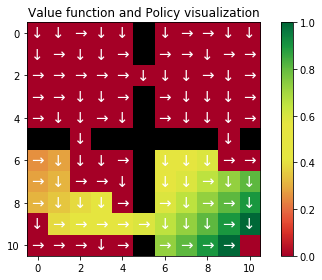

In [5]:
agent_dp = DP_PolicyEvaluation(env)
agent_dp.run(pi, delta=1e-3)
env.plot_values_policy(agent_dp.V, pi, plot_all_policy = True)

<span style="color:red"> **TODO** </span>: Shortly **comment** your result.

Because we only run the policy evaluation step on the given policy, and not the policy improvement step, we end up with the route following the policy. All paths that don't go to the terminal state wit this policy are red. The terminal state is red as well, because no ation is taken from there. 

### 1.3.  <span style="color:blue"> **TODO** </span> Monte Carlo Policy Evaluation (3pt)

We will now find $v_\pi$ simply by interacting with the environment, using MC. We will need a different `argmax` function from the one in the `numpy` library, because it always returns the first occurence of the max, while we need a random choice of the occurences. 

In [6]:
# Nothing to do in this cell.
def allmax(a):
    """ Returns all occurences of the max """
    if len(a) == 0:
        return []
    all_ = [0]
    max_ = a[0]
    for i in range(1, len(a)):
        if a[i] > max_:
            all_ = [i]
            max_ = a[i]
        elif a[i] == max_:
            all_.append(i)
    return all_

def my_argmax(v):
    """ Breaks ties randomly. """
    return random.choice(allmax(v))

From here on, we are shifting from the Dynamic Programming framework to the more general Reinforcement Learning framework of **Agent-Environment interactions**. Our abstraction for such agents is that they need to be able to `act` given a state, i.e., sample from their policy; and `learn` given a transition $\left(s,a,r,s^\prime\right)$. For practical purposes, we also need to `reset` the agent to $0$ learning, getting ready for another round of learning; similar to the Environment's `reset` method, getting ready for a new episode.

- <span style="color:red"> **TODO** </span>: **Remind** why MC Policy Evaluation should converge? <br/> 
The convergence can be guaranteed if we use an infinite number of episodes.
- <span style="color:blue"> **TODO** </span>: **Implement** MC Policy Evaluation provided the policy $\pi$ we have already evaluated. The policy is now given to the agent as we build it (in `__init__`), since we want the agent to interact using it. Please use `self.V` to store your state value estimates.

In [7]:
class MonteCarloPolicyEval():
    """ Given a policy, uses that policy to act in the environment.
    Learns its V value.
    """
    def __init__(self, env_shapes, pi, epsilon=0.1, gamma=0.9, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes

        self.gamma = gamma
        self.epsilon = epsilon
        self.V = np.zeros(self.input_shape) # Array of value estimates.
        self.pi = pi
        # You can add or remove things in here, if needed
        self.G = {}
        self.reset()
        self.reset_episode()
        
    def reset(self):
        """ 
        Reset method of your Agent. No inputs, no returns.
        """
        # TODO: Reset your agent. 
        self.V = np.zeros(self.input_shape)
    
    def reset_episode(self):
        """
        Resets the states and rewards optained in an episode
        """
        self.s = []
        self.r = []

    def act(self, s):
        """ Action in the environment, i.e. sample from our policy.
        Parameters
        ----------
        s: tuple
            State from which to give out an action
        Returns
        -------
        action : int
            Action to perform in the env
        """
        # TODO: act
        return self.pi[s]
        
    def learn(self, s, a, r, s_, d=False):
        """ MC learning the policy value from a transition. 
        Parameters
        ----------
        s, a, r, s_, d: tuple, int, float, tuple, bool
            Transition in the environment.
            From state s, taking action a, obtaining reward r and ending up in state s_
            d is the done signal, indicating if s_ is terminal.
        """
        # TODO: implement the learning of the MonteCarloPolicyEval agent
        self.s.append(s)
        self.r.append(r)
        if d:
            Gt = 0
            for i in range(len(self.s)):
                Gt = self.gamma * Gt + self.r[-(i+1)]
                state = self.s[-(i+1)]
                if state not in self.s[:-(i+1)]:
                    if state not in self.G:
                        self.G[state] = []
                    self.G[state].append(Gt)
                    self.V[state] = sum(self.G[state]) / len(self.G[state])

Now we can implement our first true learning loop! Using the [gym](https://gym.openai.com/) framework again for agent-env interactions, here's how we expect a learning loop to look like for a single episode:
```
state = env.reset()
while True:
  action = agent.act()
  next_state, reward, done, info = env.step(action)
  agent.learn(state, action, reward, next_state, done)

  if done:
    break
env.close()
```

This is what is implemented below, with a bit more to plot things out.

In [8]:
# Learning and visualization. Nothing to do here.
def learn_v_pi(agent, env, n_episodes):
    evaluations_history = []
    agent.reset()
    first = True
    # Training phase
    for ep in range(n_episodes):
        agent.reset_episode()
        s = env.reset()
        while True: # step limit implemented in Env
            action = agent.act(s) # must be = pi[s]
            s_, reward, done, info = env.step(action)
            agent.learn(s, action, reward, s_, done)
            if done:
                break
            s = s_
        if first and np.any(agent.V != 0):
            print("V visualization after the first rewarding episode observed - episode {}:".format(ep))
            env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
            first = False
        if not first and not ep % 200:
            print("V visualization after episode {}:".format(ep))
            env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
        
    print("Final V visualization: ")
    env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
    env.close()

Since we chose a deterministic policy, we actually only need Exploring Starts to go over every single state once in order to get a perfect estimate. However, we will proceed as if $\pi$ was not deterministic, and without assuming control over the initial states - we know they are random, but no more.

We need all states to be sampled. Since there are around $100$ non-terminal states, we can be sure that all will most likely have been selected once if we run $1000$ episodes.

V visualization after the first rewarding episode observed - episode 7:


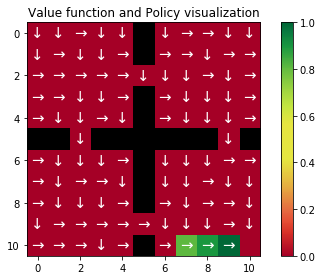

V visualization after episode 200:


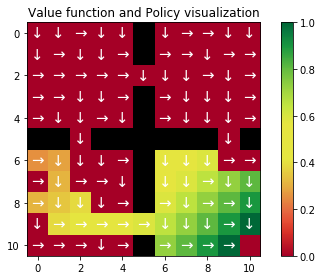

V visualization after episode 400:


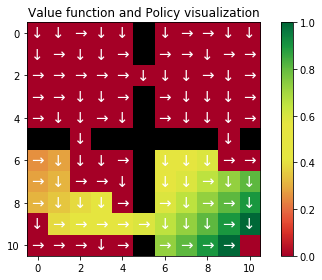

V visualization after episode 600:


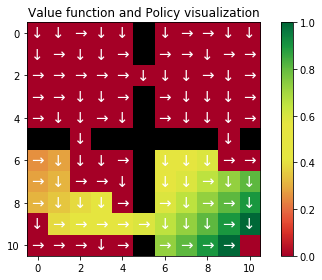

V visualization after episode 800:


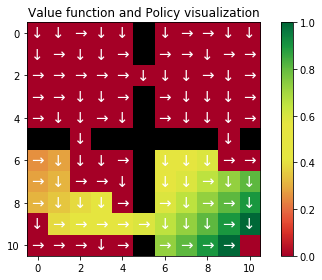

Final V visualization: 


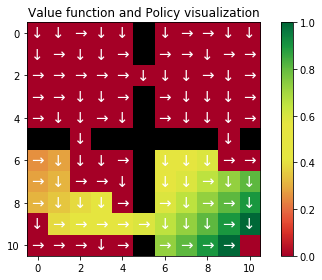

In [9]:
env = FourRoomsEnv(explo_starts=True, max_steps = 50)
shapes = (tuple([env.observation_space.spaces[i].n for i in range(len(env.observation_space.spaces))]), env.action_space.n)
d = {
    'env_shapes': shapes,
    'epsilon': 0.2,
    'gamma': env.gamma,
    'pi' : pi
}
agent_mc = MonteCarloPolicyEval(**d)
learn_v_pi(agent_mc, env, 1000)

Reminder, to compare with your DP solution:

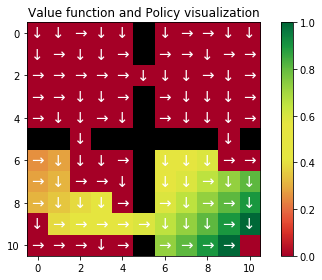

In [10]:
env.plot_values_policy(agent_dp.V, pi, plot_all_policy = True)

<span style="color:red"> **TODO** </span>: Shortly **compare** your results and the methods.

When using Monte Carlo, we end up with a similar grid. The only difference is the way we end up there. As we don't improve the policy, all paths not leading to the terminal state are red. 

## 2. <span style="color:blue"> **TODO** </span> On-Policy Monte Carlo (3pt)
Policy Evaluation is cool, but the most interesting problem to solve is the Control problem, where we need to find an optimal policy. However, we drastically changed the framework: from perfect access to the MDP dynamics, we now want to learn an optimal policy only from Agent-Environment interactions.

- <span style="color:red"> **TODO** </span> **Remind** how MC approaches the Control problem to converge. <br/> 
As discussed before, we can ensure convergence by having an infinite number of episodes. The other way to ensure convergence is exploring starts.
- <span style="color:red"> **TODO** </span> **Remind** how on-policy MC works *without exploring starts*.<br/> 
Without exploring starts, we can use an epsilon-greedy policy. This way the constant exploring is guaranteed. 
- <span style="color:blue"> **TODO** </span> **Implement** $\epsilon$-greedy MC for on-policy Control.

In [11]:
class EGMonteCarlo():
    """ Tabular method that keeps the Q-values of all the possible
    state-action pairs; updates on an episode-wise schedule
    On-Policy version using epsilon-greedy
    """
    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes
        self.Q = np.zeros((*self.input_shape, self.n_actions)) # Q value estimates. Access a state with Q[s] and state action pair with Q[s][a]
        self.gamma = gamma
        self.epsilon = epsilon
        self.G = {}
        self.reset()
        self.reset_episode()
        

    def reset(self):
        self.Q = np.zeros((*self.input_shape, self.n_actions))
        self.pi = {s:[0.25, 0.25, 0.25, 0.25] for s in env.states()}
            
    
    def reset_episode(self):
        self.s = []
        self.a = []
        self.r = []


    def act(self, s):
        return np.random.choice(range(self.n_actions), p=self.pi[s])
            

    def learn(self, s, a, r, s_, d=False):
        self.s.append(s)
        self.a.append((s, a))
        self.r.append(r)
        if d:
            Gt = 0
            for i in range(len(self.s)):
                Gt = self.gamma * Gt + self.r[-(i+1)]
                s_a = self.a[-(i+1)]
                state = s_a[0]
                if s_a not in self.a[:-(i+1)]:
                    if s_a not in self.G:
                        self.G[s_a] = []
                    self.G[s_a].append(Gt)
                    self.Q[state][s_a[1]] = sum(self.G[s_a]) / len(self.G[s_a])
                    A = my_argmax(self.Q[state])
                    for action in range(self.n_actions):
                        if action == A:
                            self.pi[state][action] = 1 - self.epsilon + self.epsilon / self.n_actions
                        else:
                            self.pi[state][action] = self.epsilon / self.n_actions
                

In [12]:
def view_train_agent(agent, env, n_episodes):
    """ Returns the steps_history of the agent"""
    evaluations_history = []
    view = [1,3,5,10,100,500, 1000]
    agent.reset()
    # Training phase
    steps_history = np.empty(n_episodes)
    for ep in range(n_episodes):
        t = 0
        s = env.reset()
        agent.reset_episode()
        while True:
            action = agent.act(s)
            s_, reward, done, info = env.step(action)
            agent.learn(s, action, reward, s_, done)
            if done:
                break
            s = s_
            t += 1
        if ep in view:
            print("Best Q and action after episode {}:".format(ep))
            best_qs = np.max(agent.Q, axis=-1)
            greedy_policy = np.argmax(agent.Q, axis=-1)
            env.plot_values_policy(best_qs, greedy_policy)

        steps_history[ep] = t
    
    print("Final Q and policy:")
    best_qs = np.max(agent.Q, axis=-1)
    greedy_policy = np.argmax(agent.Q, axis=-1)
    env.plot_values_policy(best_qs, greedy_policy)
    env.close()
    return steps_history[1:] # First is totally random

Since there is now stochastic exploration, the episodes will all reach the terminal state, if given enough time. We can remove both the step limit and Exploring Starts.

Best Q and action after episode 1:


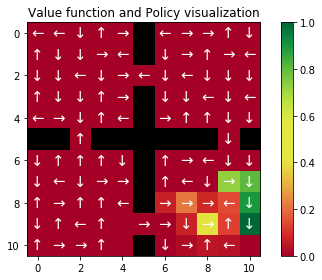

Best Q and action after episode 3:


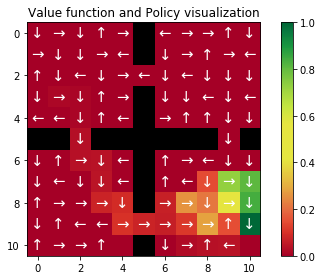

Best Q and action after episode 5:


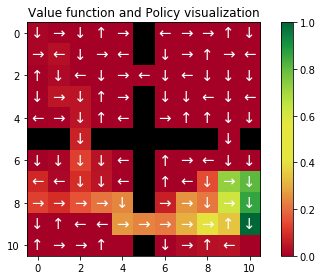

Best Q and action after episode 10:


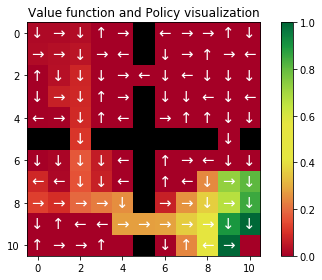

Best Q and action after episode 100:


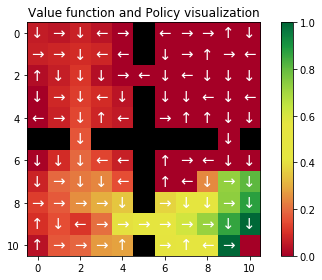

Best Q and action after episode 500:


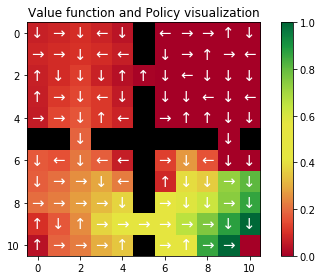

Best Q and action after episode 1000:


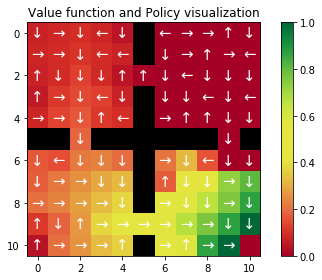

Final Q and policy:


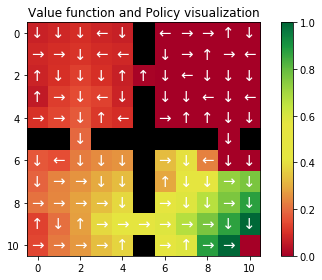

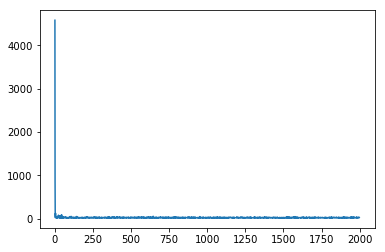

In [13]:
env = FourRoomsEnv()
shapes = (tuple([env.observation_space.spaces[i].n for i in range(len(env.observation_space.spaces))]), env.action_space.n)
d = {
    'env_shapes': shapes,
    'epsilon': 0.2,
    'gamma': env.gamma,
    'pi': pi,
}
agent = EGMonteCarlo(**d)
perf_EG = view_train_agent(agent, env, 2000)
plt.plot(perf_EG)

<span style="color:red"> **TODO** </span>: **Explain** your understanding of how MC updates its values.**Comment** the results you obtained and the evolution of the learnt policy.

The values are updated based on the epsilon-greedy approach. With a chance of epsilon, a random action is taken. With a chance of 1-epsilon, the policy is followed. The initial policy is random (each action is al likely to be chosen), After that, we evaluate an entire episode and update the policy and q-values. 

In the end, we can see that the initial state can reach the terminal state within the least amound of actions, so the policy we found is correct. The problem we have here is, because we doesn't use exploring starts, that this is only optimal from the initial state, and not from every state. 

In the final graph, we can see that in the first few episodes, the number of states visited in an episode is high, but after that, the number decreases drastically. 

## 3. <span style="color:blue"> **TODO** </span> Off-Policy Monte Carlo (3pt)
On-Policy Monte Carlo without Exploring starts is limited to soft policies. Off-Policy MC offers the promise of learning an optimal policy -and optimal values- by using a behavior policy $b$ different from the learnt policy $\pi$. In our case, we will follow the course and choose $b$ to be an $\epsilon$-greedy policy according to our $Q$ estimates, while the learnt $\pi$ policy is the true optimal policy.
- <span style="color:blue"> **TODO** </span> **Implement** MC for Off-policy Control as discussed. Use the same formalism as the On-Policy agent above.

In [14]:
class OffMonteCarloIS(EGMonteCarlo):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        

    def reset(self):
        self.Q = np.zeros((*self.input_shape, self.n_actions))
        self.C = np.zeros((*self.input_shape, self.n_actions))        
        self.pi = {s:my_argmax(s) for s in env.states()}
        self.b = {s:[0.25, 0.25, 0.25, 0.25] for s in env.states()}
            
    
    def reset_episode(self):
        self.s = []
        self.a = []
        self.r = []


    def act(self, s):
        return np.random.choice(range(self.n_actions), p=self.b[s])
            

    def learn(self, s, a, r, s_, d=False):
        self.s.append(s)
        self.a.append((s, a))
        self.r.append(r)
        if d:
            Gt = 0
            W = 1
            for i in range(len(self.s)):
                Gt = self.gamma * Gt + self.r[-(i+1)]
                s_a = self.a[-(i+1)]
                state = s_a[0]
                action = s_a[1]
                self.C[state][action] +=  W
                self.Q[state][action] += (W / self.C[state][action]) * (Gt - self.Q[state][action])
                self.pi[state] = my_argmax(self.Q[state])
                if action != self.pi[state]:
                    break
                W *= (1 / self.b[state][action])
                A = my_argmax(self.Q[state])
                for action in range(self.n_actions):
                    if action == A:
                        self.b[state][action] = 1 - self.epsilon + self.epsilon / self.n_actions
                    else:
                        self.b[state][action] = self.epsilon / self.n_actions
                

Best Q and action after episode 1:


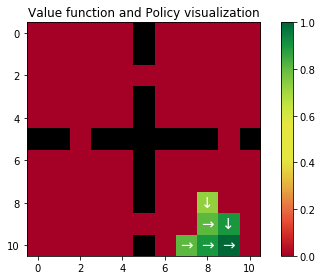

Best Q and action after episode 3:


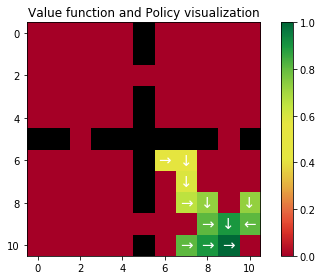

Best Q and action after episode 5:


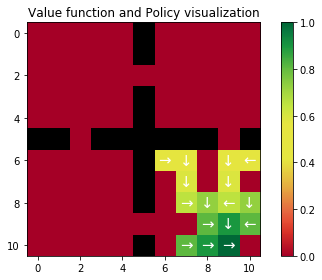

Best Q and action after episode 10:


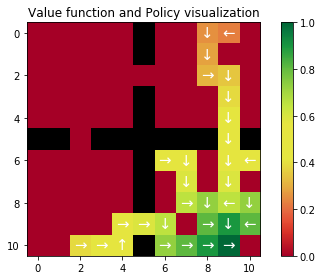

Best Q and action after episode 100:


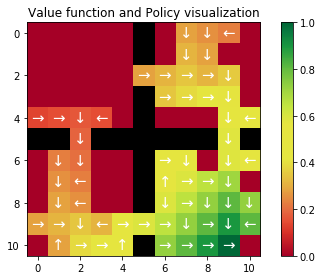

Best Q and action after episode 500:


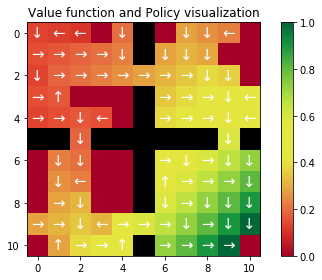

Best Q and action after episode 1000:


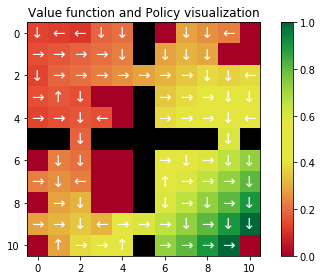

Final Q and policy:


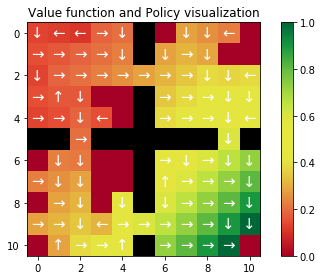

In [15]:
env = FourRoomsEnv()
shapes = (tuple([env.observation_space[i].n for i in range(len(env.observation_space))]), env.action_space.n)
d = {
    'env_shapes': shapes,
    'epsilon': 0.2,
    'gamma': env.gamma,
}
agent = OffMonteCarloIS(**d)
perf_off = view_train_agent(agent, env, 2000)

<span style="color:red"> **TODO** </span>: **Explain** briefly the difference in approach from On to Off policy MC. **Comment** the results you obtained and the evolution of the learnt policy.

The difference is that off-policy uses a seperate policy b to act than the target policy pi. This gives as a result that we find a path to the terminal state from everywhere we come. As an addition, we can see that the path from the initial state to the terminal state is still optimal, as with on-policy MC. 

The states that havn't been visited are red, and didn't get a final policy assigned. 